In [1]:
# tested in transformers==4.18.0 
from transformers import BertTokenizer,BertForSequenceClassification, BertConfig, pipeline, utils
from tqdm import tqdm
import torch
import os
import pandas as pd

In [2]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
config = BertConfig.from_pretrained('yiyanghkust/finbert-tone')

/Users/asabuncuoglu/Documents/faid-test-financial-sentiment-analysis/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
pipe = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

In [4]:
df = pd.read_csv("hf://datasets/kdave/Indian_Financial_News/training_data_26000.csv")

In [5]:
df.head()

,URL,Content,Summary,Sentiment
0,https://www.moneycontrol.com/news/business/eco...,US consumer spending dropped by a record in Ap...,consumer spending plunges 13.6 percent in Apri...,Negative
1,https://www.businesstoday.in/top-story/state-r...,State-run lenders require an urgent Rs 1.2 tri...,government will have to take a bulk of the tab...,Negative
2,https://www.financialexpress.com/economy/covid...,Apparel exporters on Wednesday urged the gover...,exporters are facing issues in terms of raw ma...,Negative
3,https://www.moneycontrol.com/news/business/mar...,Asian shares battled to extend a global reboun...,the dollar loses some ground on the safe haven...,Negative
4,https://www.financialexpress.com/industry/six-...,After India’s sovereign credit rating fell to ...,six Indian public-sector undertakings have tak...,Negative


In [7]:
data = {'y_true': [], 'y_pred': []}
pred_df = pd.DataFrame(data)

out_file = "../../data/output/indian/predictions.csv"

pred = pipe(df['Summary'].to_list())

y_pred = [p['label'] for p in pred]
y_true = df["Sentiment"].to_list()

pred_df["y_true"] = y_true
pred_df["y_pred"] = y_pred

pred_df.to_csv(out_file, index=False)

In [10]:
pred_df.value_counts()

y_true    y_pred  
Neutral   Neutral     5509
Positive  Positive    4967
Negative  Negative    4893
Positive  Neutral     3617
Negative  Neutral     3017
Neutral   Positive    2273
          Negative    1205
Negative  Positive    1077
Positive  Negative     403
Name: count, dtype: int64

In [15]:
pred_df = pd.read_csv(out_file)
pred_df.head()

,y_true,y_pred
0,Negative,Negative
1,Negative,Neutral
2,Negative,Negative
3,Negative,Negative
4,Negative,Neutral


In [21]:
y_true = pred_df["y_true"].map({"Positive": 1, "Neutral": 0, "Negative": -1})
y_pred = pred_df["y_pred"].map({"Positive": 1, "Neutral": 0, "Negative":-1})
#sf_data = pred_df["pos"]

In [22]:
nan_locations = y_pred[y_pred.isna()].index
y_pred = y_pred.drop(nan_locations)
y_true = y_true.drop(nan_locations)
#sf_data = sf_data.drop(nan_locations)

nan_locations = y_true[y_true.isna()].index
y_pred = y_pred.drop(nan_locations)
y_true = y_true.drop(nan_locations)
#sf_data = sf_data.drop(nan_locations)

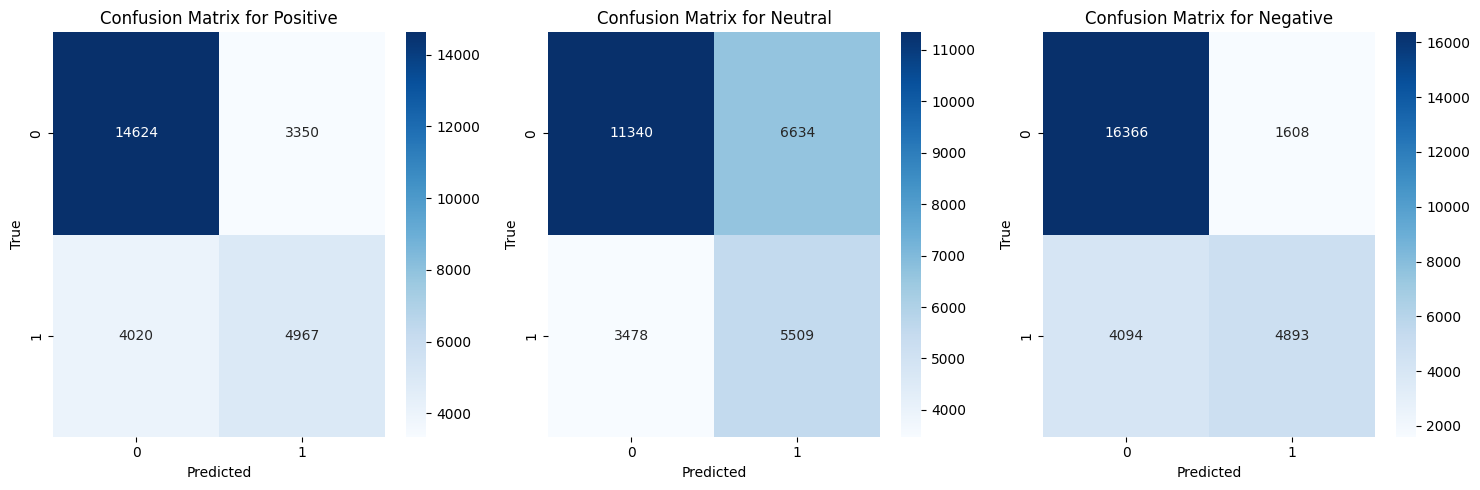

In [28]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = multilabel_confusion_matrix(y_true, y_pred, labels=[1, 0, -1])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (ax, label) in enumerate(zip(axes, ["Positive", "Neutral", "Negative"])):
    sns.heatmap(cm[i], annot=True, fmt='.0f', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {label}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()


Now, let's consider only negative and positive labels.

In [29]:
pred_df = pd.read_csv(out_file)
pred_df.head()

,y_true,y_pred
0,Negative,Negative
1,Negative,Neutral
2,Negative,Negative
3,Negative,Negative
4,Negative,Neutral


In [30]:
y_true = pred_df["y_true"].map({"Positive": 1, "Negative": -1})
y_pred = pred_df["y_pred"].map({"Positive": 1, "Negative":-1})
#sf_data = pred_df["pos"]

In [31]:
nan_locations = y_pred[y_pred.isna()].index
y_pred = y_pred.drop(nan_locations)
y_true = y_true.drop(nan_locations)
#sf_data = sf_data.drop(nan_locations)

nan_locations = y_true[y_true.isna()].index
y_pred = y_pred.drop(nan_locations)
y_true = y_true.drop(nan_locations)
#sf_data = sf_data.drop(nan_locations)

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=[1,-1])

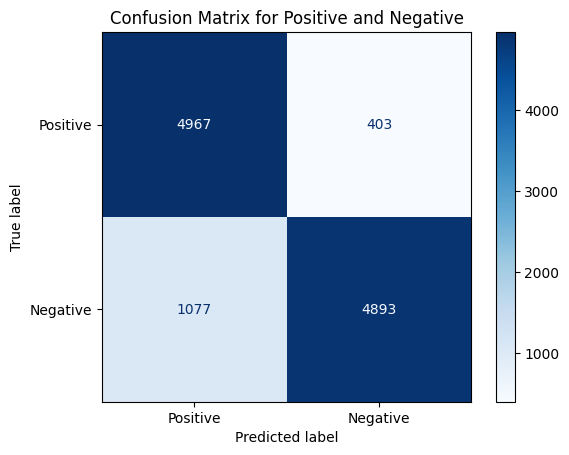

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Positive and Negative')
plt.show()

In [50]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, \
                              false_positive_rate, \
                              selection_rate

In [51]:
from sklearn.metrics import recall_score

# Define a custom recall function with average='macro' and pos_label='positive'
def recall_macro(y_true, y_pred):
    return recall_score(y_true, y_pred, average='macro')

# Construct a function dictionary
my_metrics = {
    'tpr' : recall_macro,
    'fpr' : false_positive_rate,
    'sel' : selection_rate,
    'count' : count
}

# Construct a MetricFrame
mf = MetricFrame(
    metrics=my_metrics,
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sf_data,
)

In [52]:
mf.overall

tpr          0.987420
fpr          0.024713
sel          0.508557
count    13497.000000
dtype: float64

In [53]:
mf.by_group

,tpr,fpr,sel,count
pos,,,,
GN,0.980725,0.038247,0.511867,6699.0
GS,0.994116,0.011180,0.505296,6798.0


In [54]:
mf.group_min()

tpr      0.980725
fpr       0.01118
sel      0.505296
count      6699.0
dtype: object

In [55]:
mf.group_max()

tpr      0.994116
fpr      0.038247
sel      0.511867
count      6798.0
dtype: object

In [56]:
mf.difference()

tpr       0.013391
fpr       0.027067
sel       0.006572
count    99.000000
dtype: float64

In [57]:
mf.ratio()

tpr      0.986530
fpr      0.292308
sel      0.987161
count    0.985437
dtype: float64

In [58]:
mf.difference(method='to_overall')

tpr         0.006696
fpr         0.013533
sel         0.003310
count    6798.000000
dtype: float64

In [59]:
mf.ratio(method='to_overall')

tpr      0.993220
fpr      0.452381
sel      0.993534
count    0.496333
dtype: float64

In [60]:
from fairlearn.metrics import demographic_parity_ratio
print(demographic_parity_ratio(y_true,
                               y_pred,
                               sensitive_features=sf_data))

0.9871611922296122


In [61]:
from fairlearn.metrics import equalized_odds_ratio
print(equalized_odds_ratio(y_true,
                               y_pred,
                               sensitive_features=sf_data))

0.2923076923076924


In [62]:
min(mf.ratio(method="between_groups"))

0.2923076923076924